<a href="https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# もっとも単純なRAW現像処理

## はじめに

この章ではまず、可能な限りもっとも単純なRAW現像処理を行ってみます。

## 準備

まずRAW画像を用意します。今回はSony α 7 IIIで撮影したこの画像を使います。

  ![最終的な画像](https://github.com/moizumi99/camera_raw_processing/raw/master/fig2_1.png =640x "最終的な画像")

ここで表示している画像は使用するRAWファイルから作成したRGB画像（PNGファイル）です。

元になるRAWファイルはこちらからダウンロードできます。

[https://github.com/moizumi99/camera_raw_processing/blob/master/sample.ARW?raw=true]

まず必用なモジュールをインストールします。

In [1]:
!pip install rawpy
!pip install imageio

次にRAW画像読み込み用のモジュールをインポートします。

In [0]:
import io, requests, rawpy

他に必用なモジュールがある場合はその都度読み込みます。

必用なRAWファイルを読み込みます。

In [0]:
raw = rawpy.imread("camera_raw_processing/sample.ARW")

では読み込んだRAW画像が正しいものかどうか確かめるために、rawpyの簡易現像の機能を使って表示させてみましょう。

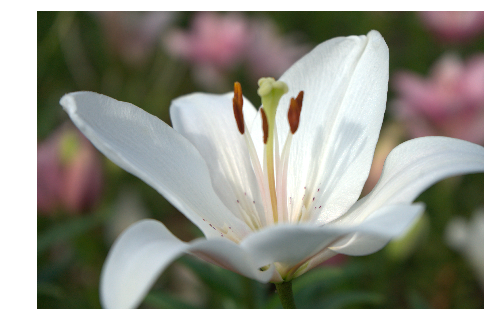

In [4]:
# Check the RAW file using rawpy.
# RAW画像をRAWPYの機能で確認。
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
img_preview = raw.postprocess(use_camera_wb=True)
imshow(img_preview)
plt.axis('off')
plt.show()

実はrawpyにはLibRaw(内部的にはdcraw)を利用したraw画像現像機能があるので、このようにして現像後の画像を見ることができます。
ただ、今回の目的はBayerから最終画像フォーマットまでの処理を一つ一つ追いかけていくことなので、これはあくまで参考とします。
最終的にこの画像と似たようなものが得られれば成功としましょう。

### 画像データ変換

扱いやすいように画像をnumpyのarrayに変換しておきましょう。まず、RAWデータのフォーマットを確認しておきます。


In [5]:
# Check the image size of the raw data
# RAW画像の画像サイズ確認。
print(raw.sizes)

ImageSizes(raw_height=4024, raw_width=6048, height=4024, width=6024, top_margin=0, left_margin=0, iheight=4024, iwidth=6024, pixel_aspect=1.0, flip=0)


RAWデータのサイズは4024 x 6048のようです。numpy arrayにデータを移しましょう。

In [0]:
# Convert to numpy so you can manipulate the pixels.
# 画像をnumpy形式に変更。これで操作が容易になる。
import numpy as np
h, w = raw.sizes.raw_height, raw.sizes.raw_width
raw_image = raw.raw_image.copy()
raw_array = np.array(raw_image).reshape((h, w)).astype('float')

このデータを無理やり画像として見ようとするとこうなります。

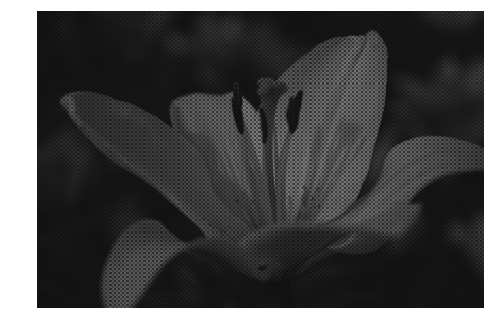

In [7]:
# Let's see the Bayer pattern image as is.
# Bayer画像をそのままグレイスケール画像として見てみる。
outimg = raw_array.copy()
outimg = outimg.reshape((h, w))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')
plt.axis('off')
plt.show()

拡大するとこんな感じです

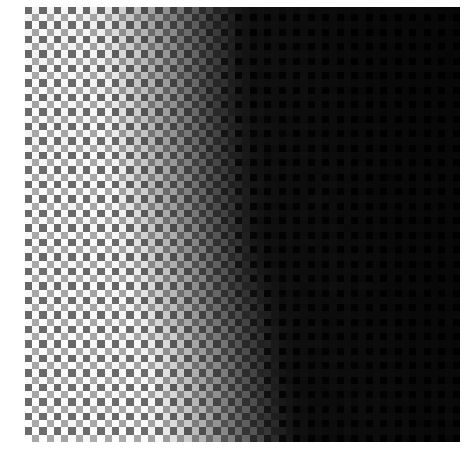

In [8]:
# Let's maginify the image to see the details.
# RAW画像の拡大。
plt.figure(figsize=(8, 8))
imshow(outimg[1310:1370, 2620:2680], cmap='gray')
plt.axis('off')
plt.show()

明るいところが緑、暗いところが赤や青の画素のはずです。でも、これじゃなんのことやらさっぱりわかりませんね。
そこで、デモザイク処理でフルカラーの画像を作る必要があるわけです。

## ブラックレベル補正

RAWデータの黒に対応する値は通常０より大きくなっています。画像を正常に表示するにはこれを0にもどす必要があります。これをやって置かないと黒が十分黒くない、カスミがかかったような眠い画像になってしまいますし、色もずれてしまいます。

まず、rawpyの機能でブラックレベルを確認しましょう。


In [9]:
# Black level correction values.
# ブラックレベルの確認。
blc = raw.black_level_per_channel
print(blc)

[512, 512, 512, 512]


どうやら全チャンネルでブラックレベルは512のようですが、他のRAWファイルでもこのようになっているとは限りません。各画素ごとのチャンネルに対応した値を引くようにしておきましょう。

さて、先程とりだしたrawデータの配列は以下の方法で確認できます。

In [10]:
# Check the Bayer pattern. 0 = Red, 1 = Green, 2 = Blue, 3 = Green.
# ベイヤーパターンの確認。
bayer_pattern = raw.raw_pattern
print(bayer_pattern)

[[0 1]
 [1 2]]


どうやら0が赤、1が緑、2が青をしめしているようです。つまり、画像データの中から2x2のブロックを重複なくとりだすと、その中の左上が赤、右下が青、その他が緑、という事のようです。
このチャンネルに合わせて正しいブラックレベルを引きます。

In [11]:
# Do black level correction.
# ブラックレベル補正。
print("Minimum and Maximum before black level correction: ", raw_array.min(), raw_array.max())
blc_raw = raw_array.copy()
for y in range(0, h, 2):
    for x in range(0, w, 2):
        blc_raw[y + 0, x + 0] -= blc[bayer_pattern[0, 0]]
        blc_raw[y + 0, x + 1] -= blc[bayer_pattern[0, 1]]
        blc_raw[y + 1, x + 0] -= blc[bayer_pattern[1, 0]]
        blc_raw[y + 1, x + 1] -= blc[bayer_pattern[1, 1]]
print("Minimum and Maximum after black level correction: ", blc_raw.min(), blc_raw.max())

Minimum and Maximum before black level correction:  0.0 8180.0
Minimum and Maximum after black level correction:  -512.0 7668.0


処理後の画像は、最大値と最小値が512小さくなっているのが確認できました。


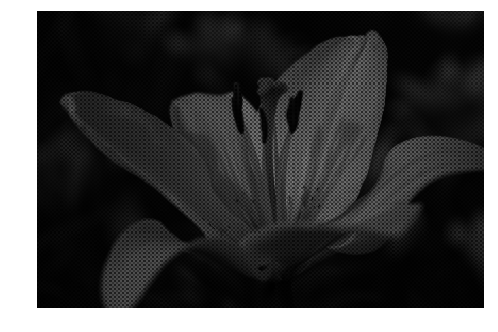

In [12]:
# Show the image after black level correction.
# ブラックレベル補正後の画像の確認。少し暗くなっている。
outimg = blc_raw.copy()
outimg = outimg.reshape((h, w))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')
plt.axis('off')
plt.show()

画像も少し暗くなっています。

## 簡易デモザイク

次にとうとうBayer配列からフルカラーの画像を作ります。これが終わるとやっと画像がまともに確認できるようになります。

この処理はデモザイクと呼ばれることが多いです。本来デモザイクはカメラ画像処理プロセス（ISP)の肝になる部分で、画質のうち解像感や、偽色などの不快なアーティファクトなどを大きく左右します。
したがって手を抜くべきところではないのですが、今回は簡易処理なので、考えうる限りでもっとも簡単な処理を採用します。

その簡単な処理というのは、ようするに3色の情報を持つ最小単位の2x2のブロックから、1画素のみをとりだす、というものです。

![Bayer配列からRGB１画素への簡単な変換](https://github.com/moizumi99/camera_raw_processing/raw/master/fig2_2.png "Bayer配列からRGB１画素への簡単な変換")

結果として得られる画像サイズは1/4になりますが、もとが24Mもあるので、まだ6M残っています。今回の目的には十分でしょう。
なお、解像度低下をともなわないデモザイクアルゴリズムは次回以降とりあげようと思います。


では、簡易デモザイク処理してみましょう。なお、2x2ピクセルの中に2画素ある緑は平均値をとります。

In [0]:
# Simplified demosaicing.
# 簡易デモザイク処理。
dms_img = np.zeros((h//2, w//2, 3))
for y in range(0, h, 2):
    for x in range(0, w, 2):
        colors = [0, 0, 0, 0]
        colors[bayer_pattern[0, 0]] += blc_raw[y + 0, x + 0]
        colors[bayer_pattern[0, 1]] += blc_raw[y + 0, x + 1]
        colors[bayer_pattern[1, 0]] += blc_raw[y + 1, x + 0]
        colors[bayer_pattern[1, 1]] += blc_raw[y + 1, x + 1]
        dms_img[y // 2, x // 2, 0] = colors[0]
        dms_img[y // 2, x // 2, 1] = (colors[1] + colors[3])/ 2
        dms_img[y // 2, x // 2, 2] = colors[2]

さてこれでフルカラーの画像ができたはずです。見てみましょう。

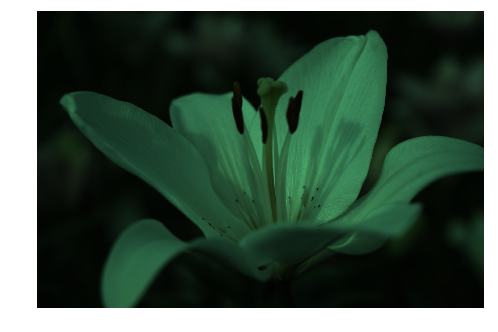

In [14]:
outimg = dms_img.copy()
outimg = outimg.reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

でました。画像が暗く、色も変ですが、それは予定通りです。そのあたりをこれから直していきます。

## ホワイトバランス補正

次にホワイトバランス補正をかけます[^4]。これは、センサーの色ごとの感度や、光のスペクトラムなどの影響を除去して、本来の白を白として再現するための処理です。
そのためには各色の画素に、別途計算したゲイン値をかけてあげます。今回はカメラが撮影時に計算したゲイン値をRAWファイルから抽出して使います。

[^4]: ダイアグラムでの処理の順番に比べて、デモザイクとホワイトバランスの順番が逆になっていますが、今回採用した簡易デモザイクでは影響ありません。

ますはどんなホワイトバランス値かみてみましょう。RAWファイルの中に記録されたゲインを見てみましょう。

In [15]:
# White balance gains from the camera.
# ホワイトバランスの確認。
wb = np.array(raw.camera_whitebalance)
print(wb)

[2288. 1024. 1544. 1024.]


これは赤色にかけるゲインがx2288/1024、緑色がx1.0、青色がx1544/1024、という事のようです。処理してみましょう。

In [0]:
# Apply white balance correction.
# ホワイトバランス補正。
img_wb = dms_img.copy().flatten().reshape((-1, 3))
for index, pixel in enumerate(img_wb):
    pixel = pixel * wb[:3] /max(wb)
    img_wb[index] = pixel

表示してみます。

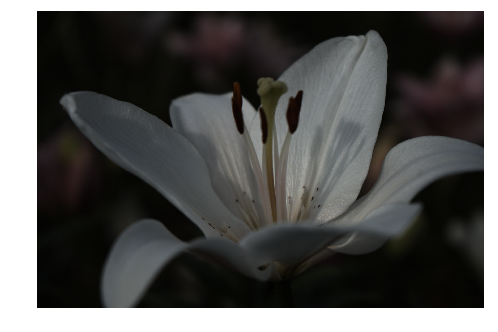

In [17]:
# Show the image after white balance correction.
# ホワイトバランス補正後の画像。
outimg = img_wb.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

色がだいぶそれらしくなりました。

## カラーマトリクス補正

次にカラーマトリクス補正を行います。カラーマトリクスというのは処理的には3x3の行列に、3色の値を成分としたベクトルをかけるという処理になります。

(TODO: 数式)

なぜこんな事をするかというと、カメラのセンサーの色ごとの感度が人間の目とは完全には一致しないためです。例えば人間の目はある光の周波数の範囲を赤、青、緑、と感じるのですが、センサーが緑を検知する範囲は人間が緑と感じる領域とは微妙に異なっています。同じように青や赤の範囲も違います。これは、センサーが光をなるべく沢山取り込むため、だとか、製造上の制限、などの理由があるようです。
さらに、人間の目には、ある色を抑制するような領域まであります。これはセンサーで言えばマイナスの感度があるようなものですが、そんなセンサーは作れません。

こういったセンサー感度と人間の目の間隔とがなるべく小さくなるように、3色を混ぜて、より人間の感覚に近い色を作り出す必要があります。この処理を通常は行列を使って行い、これをカラーマトリクス処理と呼びます。

さて、ここでrawpyを使ってRAWデータの中に含まれる、マトリクスを調べるとこんなふうになってしまいます。

In [18]:
# The color_matrix from raw_py doesn't seem to be right.
# raw_pyを使って得たカラーマトリクス値は正しくない。
print(raw.color_matrix)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


仕方がないのでexiftoolsでマトリクスを元のARWファイルから取り出したところ、次のような値のようです。

```
Color Matrix  : 1141 -205 88 -52 1229 -154 70 -225 1179
```
この値を使って処理を行いましょう。

In [0]:
# Use the matrix from the exif information of the ARW file acquired by exiftool.
# 元のARWファイルからexiftoolを使って得たマトリクスを使用。
color_matrix = np.array([[1141, -205, 88], [-52, 1229, -154], [70, -225, 1179]]) / 1024

In [0]:
# Apply Color matrix to the image.
# カラーマトリクス補正。
img_ccm = np.zeros_like(img_wb)
for index, pixel in enumerate(img_wb):
    pixel = np.dot(color_matrix, pixel)
    img_ccm[index] = pixel

表示させてみます。

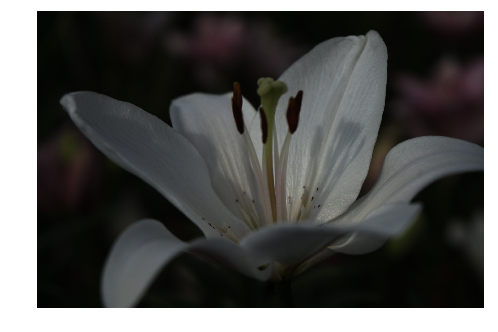

In [21]:
# Show the image after color matrix correction.
# カラーマトリクス補正後の画像。
outimg = img_ccm.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

あまり影響が感じられません。元のセンサーが良いので極端な補正はかけなくてよいのかもしれません。

## ガンマ補正

最後にガンマ補正をかけます。
ガンマ補正というのは、もともとテレビがブラウン管だった頃にテレビの出力特性と信号の強度を調整するために使われていたものです。
今でも残っているのは、ガンマ補正による特性が結果的に人間の目の非線形的な感度と相性が良かったからのようです。
そんなわけで現在でもディスプレイの輝度は信号に対してブラウン管と似たような信号特性を持って作られており、画像にはガンマ補正をかけておかないと出力は暗い画像になってしまいます。

ガンマ特性自体は次の式で表されます

$$ y = x^{2.2}$$

グラフにするとこうなります。


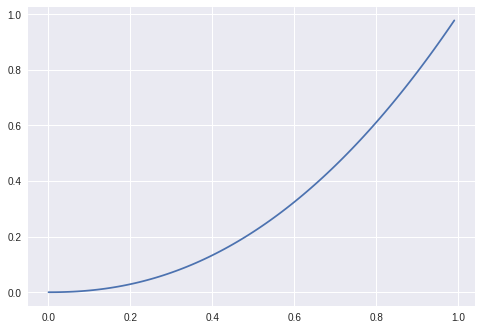

In [22]:
xs = np.arange(0.0, 1.0, 0.01)
ys = np.power(xs, 2.2)
plt.plot(xs, ys)
plt.show()

ガンマ補正はこれを打ち消す必要があるので、このようになります。


$$ y = x^{\frac{1}{2.2}} $$

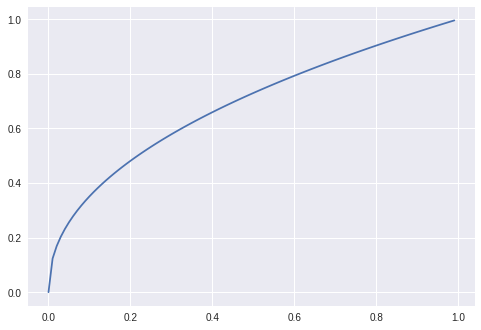

In [23]:
xs = np.arange(0.0, 1.0, 0.01)
ys = np.power(xs, 1/2.2)
plt.plot(xs, ys)
plt.show()

それではガンマ補正をかけてみましょう。

In [0]:
# Apply gamma correction.
# ガンマ画像補正。

import math

img_gamma = img_ccm.copy().flatten()
img_gamma[img_gamma < 0] = 0
img_gamma = img_gamma/img_gamma.max()
for index, val in enumerate(img_gamma):
    img_gamma[index] = math.pow(val, 1/2.2)
img_gamma = img_gamma.reshape((h//2, w//2, 3))

画像を表示します。

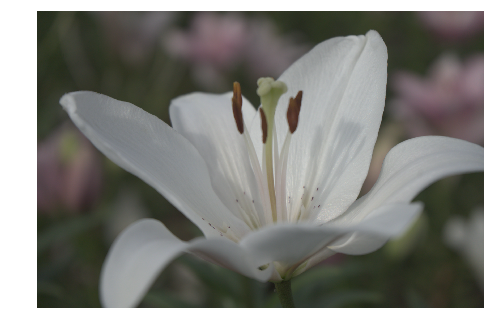

In [25]:
# Show the image after gamma correction.
# ガンマ補正後の画像の確認。
outimg = img_gamma.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

だいぶきれいになりました。

## 画像の保存

最後にセーブしておきます。

In [0]:
import imageio

outimg = img_gamma.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg * 255
imageio.imwrite("sample.png", outimg.astype('uint8'))

## まとめ

今回はrawpyを使ってカメラのRAWファイルからBayerデータを取り出し、Pythonでできるだけスクラッチから簡易的なカメラ画像処理を作成して、RAW現像を行いました。
今の所、周辺減光補正、ノイズ処理、エッジ強調がない、など主要な処理が抜けていますし、デモザイクは簡易的なものですので、次章以降こういった処理を追加していきます。